Os dados contêm as seguintes colunas relevantes para uma análise de RDD:

* `Attendance`: variável contínua de presença.
* `Treatment`: variável binária indicando se o indivíduo recebeu o tratamento.
* `Attendance_c`: versão centralizada da variável de presença (isto é, $\text{Attendance} - \text{cutoff}$).
* `Performance`: desfecho contínuo que queremos explicar (ex: nota ou avaliação final).

Vamos agora:

1. Considerar o ponto de corte em `Attendance_c = 0` (ou seja, `Attendance = cutoff`);
2. Comparar o ajuste da regressão local para diferentes larguras de banda (±5, ±10, ±20).

In [2]:
# Carregar os dados enviados
import pandas as pd

caminho_arquivo = "../data/attendance_performance.csv"
df = pd.read_csv(caminho_arquivo)

# Exibir as primeiras linhas para inspeção
df.head()


,Unnamed: 0,Performance,Treatment,Attendance,Attendance_c
0,1,77.702123,0,88.963102,9.703697
1,2,76.427011,0,88.842512,9.583107
2,3,61.506374,1,62.684335,-16.575070
3,4,76.465925,0,83.401473,4.142068
4,5,87.255437,0,94.567788,15.308383


## Efeito da largura de banda

O código a seguir ilusta o efeito de diferentes **larguras de banda (±2, ±5, ±10)** .

**Interpretação:**

* **Eixo x**: `Attendance_c` representa a presença centrada no ponto de corte.
* **Eixo y**: `Performance`, o desfecho de interesse.
* **Cores**: indicam se o indivíduo recebeu (`Treatment = 1`) ou não o tratamento.
* **Linha preta**: regressão local estimada.

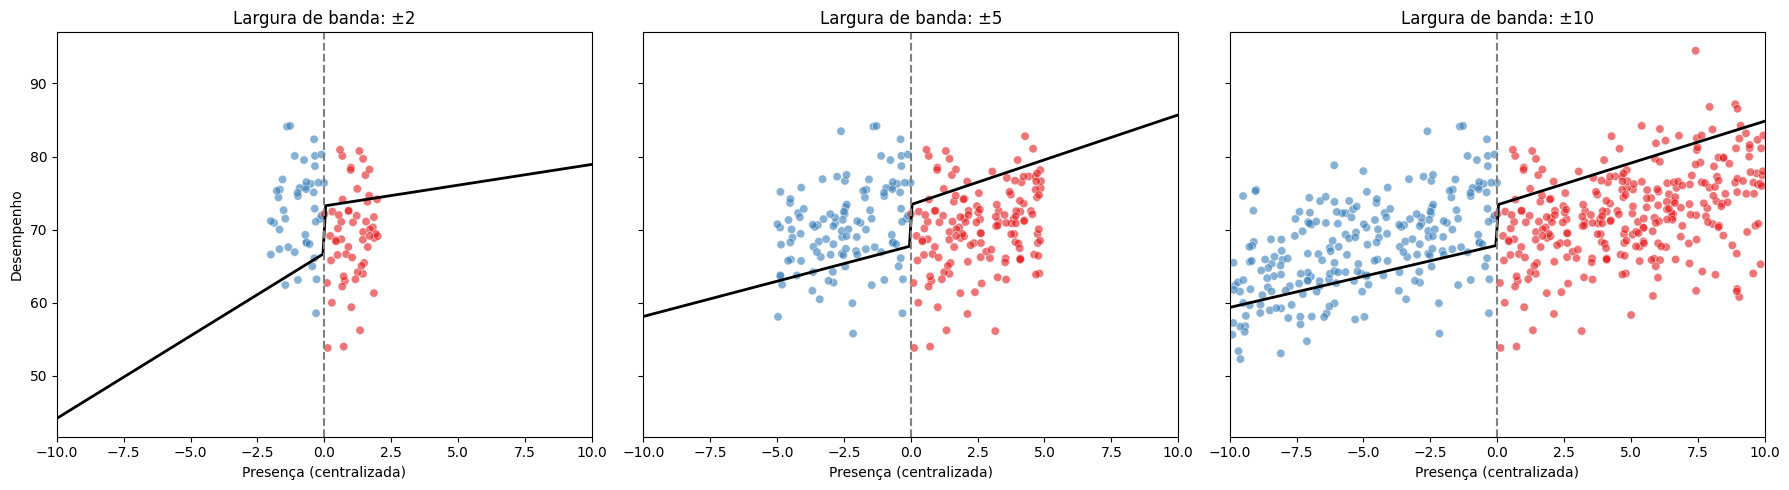

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Definir ponto de corte em Attendance_c = 0
cutoff = 0
bandwidths = [2, 5, 10]



# Plot
fig, axes = plt.subplots(1, len(bandwidths), figsize=(18, 5), sharey=True)
x_min = -max(bandwidths)
x_max = max(bandwidths)

for ax, bw in zip(axes, bandwidths):
    df_bw = df[(df['Attendance_c'] >= -bw) & (df['Attendance_c'] <= bw)]

    model = smf.ols("Performance ~ Attendance_c * Treatment", data=df_bw).fit()

    x_vals = np.linspace(x_min, x_max, 200)
    pred_df = pd.DataFrame({
        "Attendance_c": x_vals,
        "Treatment": (x_vals >= 0).astype(int)
    })
    pred_df["Performance_pred"] = model.predict(pred_df)

    sns.scatterplot(data=df_bw, x="Attendance_c", y="Performance", hue="Treatment",
                    palette="Set1", ax=ax, alpha=0.6, legend=False)
    ax.plot(pred_df["Attendance_c"], pred_df["Performance_pred"], color="black", lw=2)
    ax.axvline(0, color="gray", linestyle="--")
    ax.set_xlim(x_min, x_max)
    ax.set_title(f"Largura de banda: ±{bw}")
    ax.set_xlabel("Presença (centralizada)")
    if bw == bandwidths[0]:
        ax.set_ylabel("Desempenho")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.show()


O código abaixo constrói a tabela com os **efeitos causais estimados** para as larguras de banda de ±2, ±5 e ±10:

<center>

| Largura de banda (±) | Efeito causal estimado | Erro padrão | p-valor  |
| -------------------- | ---------------------- | ----------- | -------- |
| 2                    | 6.482                  | 2.445       | 0.0093   |
| 5                    | 5.656                  | 1.344       | 3.59e-05 |
| 10                   | 5.528                  | 0.984       | 3.20e-08 |

</center>

Interpretação:

* Com **±2**, a estimativa é a mais próxima do ponto de corte (mais "local"), mas com maior incerteza (erro padrão maior).
* À medida que aumentamos o bandwidth para ±5 e ±10, o erro padrão diminui, e o p-valor fica ainda mais significativo.
* O valor estimado do efeito é relativamente **estável e consistente**, o que sugere **robustez da descontinuidade**.

In [7]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Recarregar os dados
df = pd.read_csv("../data/attendance_performance.csv")

# Larguras de banda atualizadas
bandwidths_novas = [2, 5, 10]

# Estimar os efeitos causais
resultados_novos = []

for bw in bandwidths_novas:
    df_bw = df[(df['Attendance_c'] >= -bw) & (df['Attendance_c'] <= bw)]
    model = smf.ols("Performance ~ Attendance_c * Treatment", data=df_bw).fit()
    efeito = model.params.get("Treatment", np.nan)
    erro = model.bse.get("Treatment", np.nan)
    pval = model.pvalues.get("Treatment", np.nan)
    resultados_novos.append({
        "Largura de banda (±)": bw,
        "Efeito causal estimado": efeito,
        "Erro padrão": erro,
        "p-valor": pval
    })

# Gerar DataFrame de resultados
df_resultados_novos = pd.DataFrame(resultados_novos)
df_resultados_novos


,Largura de banda (±),Efeito causal estimado,Erro padrão,p-valor
0,2,6.48199,2.444593,9.345029e-03
1,5,5.65604,1.344070,3.592422e-05
2,10,5.52782,0.984397,3.204673e-08


## O efeito causal visualmente

O gráfico abaixo mostra o **salto na linha preta** no ponto de corte `Attendance_c = 0`, que representa o **efeito causal estimado do tratamento** sobre o desempenho (`Performance`).

A anotação "Salto ≈ ..." indica a **diferença estimada nas médias preditas** entre os grupos tratados e não tratados exatamente no ponto de corte — esse é o estimador RDD clássico.

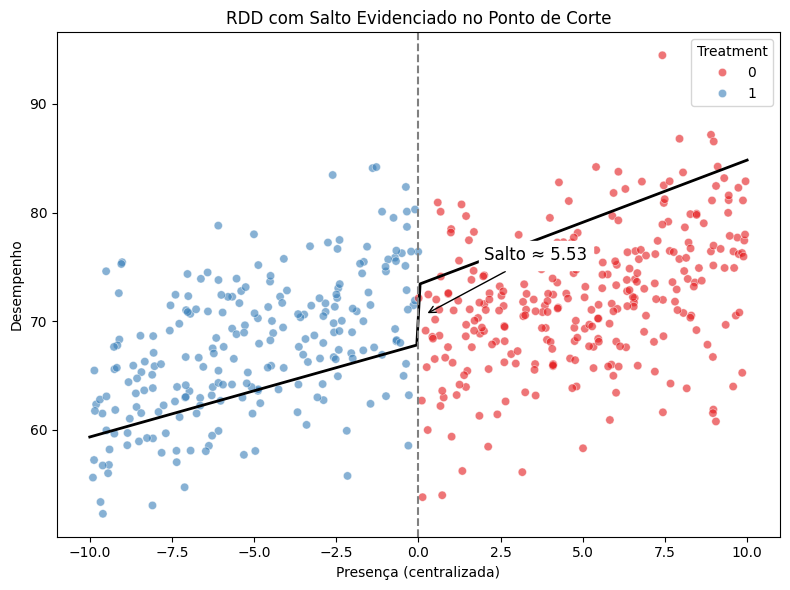

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Usar a banda de ±10 para o gráfico com anotação do salto
bw = 10
df_bw = df[(df['Attendance_c'] >= -bw) & (df['Attendance_c'] <= bw)]
model = smf.ols("Performance ~ Attendance_c * Treatment", data=df_bw).fit()

x_vals = np.linspace(-bw, bw, 200)
pred_df = pd.DataFrame({
    "Attendance_c": x_vals,
    "Treatment": (x_vals >= 0).astype(int)
})
pred_df["Performance_pred"] = model.predict(pred_df)

# Ponto de corte
left_pred = model.predict({"Attendance_c": [0], "Treatment": [0]})[0]
right_pred = model.predict({"Attendance_c": [0], "Treatment": [1]})[0]

# Gráfico com anotação
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_bw, x="Attendance_c", y="Performance", hue="Treatment",
                palette="Set1", alpha=0.6)
plt.plot(pred_df["Attendance_c"], pred_df["Performance_pred"], color="black", lw=2)
plt.axvline(0, color="gray", linestyle="--")

# Anotação do salto
plt.annotate(f"Salto ≈ {right_pred - left_pred:.2f}",
             xy=(0.2, (right_pred + left_pred) / 2),
             xytext=(2, (right_pred + left_pred) / 2 + 5),
             arrowprops=dict(arrowstyle="->", color="black"),
             fontsize=12, color="black", backgroundcolor="white")

plt.xlabel("Presença (centralizada)")
plt.ylabel("Desempenho")
plt.title("RDD com Salto Evidenciado no Ponto de Corte")
plt.tight_layout()
plt.show()